In [22]:
import pandas as pd
import numpy as np
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Reading data from 7 or 10 data simulation files (data7 or data respectively)  

In [23]:
#data
data = pd.read_csv('drive/Shared drives/ATLAS project/data/data7.csv')

# add features
data['delta_z'] = np.abs(data['Track_z0']-data['Prime_vx_z'])
data["sin_teta"]= np.sin(data["Track_theta"])
data["Track_eta"]= np.cos(data["Track_eta"])
data = data.drop(columns=['Track_theta','Unnamed: 0'])

# target
target = pd.read_csv('drive/Shared drives/ATLAS project/data/target7.csv')

# Convert the type on target to boolean 
class_as_list =[]
for i in target["class"]:
  # class true is a track that related to primery vertex that truth with true track (1) and vertex (2) of simulation
  if i == 1 or i == 2:
    class_as_list.append(True)
  else:
    class_as_list.append(False)
y = pd.DataFrame({'class':class_as_list})
print(data.head())
print(data.shape)
print(y.shape)

   EventNumber  Track_omega  d0_significance  ...  Track_eta   delta_z  sin_teta
0          780     0.225089         0.392965  ...  -0.474817  0.902202  0.249488
1          780     0.048385        -0.936943  ...  -0.665516  0.243484  0.198721
2          780    -0.012739         0.135812  ...   0.238140  0.025775  0.494225
3          780     0.210554         0.768860  ...  -0.607174  0.983916  0.213996
4          780     0.007321        -0.081161  ...   0.258606  0.014543  0.503359

[5 rows x 10 columns]
(17062463, 10)
(17062463, 1)


Cutting data on Omega variable that define the distanse from zero point of primery vertex.
We will see when we don't cut, a accuracy is high, but the error of 
FPR (error of false we said are true) is also high.
But if we cut on +- 2 truly a accuracy is less high, but a error of FPR smaller than 2% so we will cut thus.      

In [ ]:
#cutting of absulute 2 on Track omega feature 
msk = data.index[np.abs(data['Track_omega'])<2]
data = data.iloc[msk]
y = y.iloc[msk]

In [25]:
data

,EventNumber,Track_omega,d0_significance,Prime_vx_z,Track_z0,TrackPt,Track_phi,Track_eta,delta_z,sin_teta
8046801,1076922,1.793567,-2.295631,-46.050762,-41.712532,605.258423,1.854429,0.040142,4.338230,0.413433
8728129,1078095,-27.655222,0.632506,76.850677,-13.325591,811.569092,-1.951004,-0.276273,90.176269,0.306680
13498334,1097668,-11.951909,-1.612359,29.697971,-22.538105,778.670898,-0.942776,-0.551266,52.236076,0.228806
14139753,1099597,-44.034565,-1.078256,18.210093,-36.145248,1210.025635,-0.578920,0.782612,54.355341,0.810124
7700331,1068401,7.610914,1.435406,-15.226106,-6.401646,588.939331,2.760205,0.848600,8.824460,0.862479
...,...,...,...,...,...,...,...,...,...,...
5109877,1059442,58.442356,-0.414848,-118.023987,-21.902798,927.192139,1.495493,0.469582,96.121189,0.608007
6549775,1065474,-2.098295,-0.841404,-3.589489,-6.227436,1849.989136,2.396780,0.763131,2.637947,0.795427
10764185,1087990,35.637917,1.418127,-47.442528,61.980190,834.363892,-2.356595,-0.214831,109.422718,0.325690
12779684,1095064,37.115295,0.660893,-50.760216,44.376686,2128.242676,0.299353,-0.023211,95.136902,0.390125


In [26]:
y

,class
8046801,True
8728129,False
13498334,False
14139753,False
7700331,False
...,...
5109877,False
6549775,False
10764185,False
12779684,False


In [10]:
print(data.shape[1])
print(y.shape[1])

10
1


The data is imbalance. 
If don't cut by Omega variable the tendency in favor of false, because all detector space state on 300 mm but the primery vertex exist in around 4 mm, but if cutting a Omega on +-2 the tendency in favor of true.

In [27]:
def data_clas_info(X,c_y):
  print("-------------DATA INFO------------")
  count_t = 0
  for i in c_y["class"]:
    if i is True:
      count_t+=1
  count_f = 0                                                                                                                            
  for i in c_y["class"]:
    if i is False:
      count_f+=1
  print('Num of Data: {}'.format(len(c_y)))
  
  print('true rate: {}'.format(count_t/len(c_y)))
  print('false rate: {}'.format(count_f/len(c_y)))

  return [count_t,count_f,count_t/len(c_y),count_f/len(c_y)]

count_t,count_f, ratio_t ,ratio_f= data_clas_info(data.copy(),y.copy())

-------------DATA INFO------------
Num of Data: 2000000
true rate: 0.108068
false rate: 0.891932


There is 9 consecutive variables and target variable binary that selected by a physical specialist

In [ ]:
print("data:")
print(data.dtypes)
print("\n")
y.dtypes

data:
EventNumber          int64
Track_omega        float64
d0_significance    float64
Prime_vx_z         float64
Track_z0           float64
TrackPt            float64
Track_phi          float64
Track_eta          float64
delta_z            float64
sin_teta           float64
dtype: object




class    bool
dtype: object

In [28]:
def get_cut_data_by_treshold(data_, y_,pred_,is_bef_train,class_name,treshold):
  data_y = data_ 
  data_y[class_name] = y_[class_name]
  c_pred = None    
  if(not is_bef_train):        
    data_y['pred'] = pred_["pred"]
    c_pred = data_y.loc[np.logical_and(np.abs(data_y['Track_omega'])>treshold,np.abs(data_y['Track_omega'])<=treshold+0.1),['pred']]
  c_X = data_y.loc[np.logical_and(np.abs(data_y['Track_omega'])>treshold,np.abs(data_y['Track_omega'])<=treshold+0.1),'EventNumber':'sin_teta']
  c_y = data_y.loc[np.logical_and(np.abs(data_y['Track_omega'])>treshold,np.abs(data_y['Track_omega'])<=treshold+0.1),[class_name]]
  return c_X,c_y ,c_pred

In [29]:
def create_graph(x_axis,y_axis,tresholds,x_label,y_label,title):
  lists = [x_axis,y_axis,tresholds]
  df_to_graph = pd.DataFrame.from_records(lists).T
  df_to_graph.columns = [x_label, y_label, 'Thresholds']
  ax = df_to_graph.plot(x='Thresholds',  title=title)
  ax.set_xlabel("Decision Threshold")
  ax.set_ylabel("Score")

The data are unbalanced and therefore we will see the relationship between the True classification and the False classification at the significant points of the study and the cross-sectional points of the omega variable

0.0
-------------DATA INFO------------
Num of Data: 776797
true rate: 0.95327221912546
false rate: 0.04672778087453994
0.1
-------------DATA INFO------------
Num of Data: 337809
true rate: 0.9310142713782048
false rate: 0.06898572862179515
0.2
-------------DATA INFO------------
Num of Data: 134728
true rate: 0.8800768956712784
false rate: 0.11992310432872157
0.3
-------------DATA INFO------------
Num of Data: 61138
true rate: 0.7734142431875429
false rate: 0.22658575681245707
0.4
-------------DATA INFO------------
Num of Data: 35916
true rate: 0.6071388796079742
false rate: 0.39286112039202586
0.5
-------------DATA INFO------------
Num of Data: 27971
true rate: 0.443209037932144
false rate: 0.5567909620678559
0.6
-------------DATA INFO------------
Num of Data: 26497
true rate: 0.30671396761897574
false rate: 0.6932860323810243
0.7
-------------DATA INFO------------
Num of Data: 27687
true rate: 0.22259544190414274
false rate: 0.7774045580958573
0.8
-------------DATA INFO------------
Nu

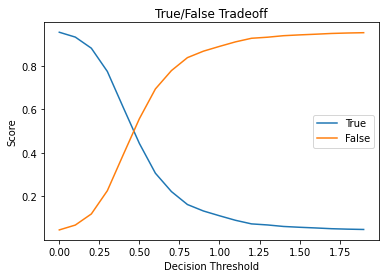

In [ ]:
ratios_f = []
ratios_t = []
tresholds=[]
for i in np.linspace(0,1.9,num=20):
  treshold = round(i,1)
  print(treshold)
  tresholds.append(treshold)
  c_X,c_y,_ = get_cut_data_by_treshold(data.copy(),y.copy(),None,True,'class',treshold)
  c_t, c_f,ratio_t,ratio_f = data_clas_info(c_X,c_y)
  ratios_f.append(ratio_f)
  ratios_t.append(ratio_t)
create_graph(ratios_t,ratios_f,tresholds,'True', 'False','True/False Tradeoff')

In [ ]:
#calc the preformence of the model
from sklearn.metrics import confusion_matrix, accuracy_score,roc_auc_score
def get_score(y_train,pred_train,y_test,pred_test):
  print("#############scores on train set################") 
  confm = confusion_matrix(y_train, pred_train)
  print("confusion matrix: ", confm)
  tn, fp, fn, tp = confm.ravel()
  print("tn:",tn, "fp:", fp, "fn:" ,fn,"tp:" ,tp)

  # Error rate : 
  err_rate = (fp + fn) / (tp + tn + fn + fp)
  print("Error rate: ", err_rate)
  # Accuracy : 
  acc_ = (tp + tn) / (tp + tn + fn + fp)
  print("Accuracy: ", acc_)
  # Sensitivity (tpr): 
  tpr = tp / (tp + fn)
  print("Sensitivity(tpr): ", tpr)
  # Specificity 
  sens = tn / (tn + fp)
  print("Specificity: ", sens)
  # False positive rate (FPR)
  fpr = fp / (tn + fp)
  print("False positive rate: ", fpr)
  #Roc auc score
  roc_auc = roc_auc_score(y_train, pred_train)
  print("roc_auc score: ", roc_auc)
  print("")
  print("#############scores on test set################")
  confm = confusion_matrix(y_test, pred_test)
  print("confusion matrix: ", confm)
  tn, fp, fn, tp = confm.ravel()
  print("tn:",tn, "fp:", fp, "fn:" ,fn,"tp:" ,tp)
  # Error rate : 
  err_rate = (fp + fn) / (tp + tn + fn + fp)
  print("Error rate: ", err_rate)
  # Accuracy : 
  acc = (tp + tn) / (tp + tn + fn + fp)
  print("Accuracy: ", acc)
  # Sensitivity (tpr): 
  tpr = tp / (tp + fn)
  print("Sensitivity(tpr): ", tpr)
  # Specificity 
  sens = tn / (tn + fp)
  print("Specificity: ", sens)
  # False positive rate (FPR)
  fpr = fp / (tn + fp)
  print("False positive rate: ", fpr)
  #Roc auc score
  roc_auc = roc_auc_score(y_test, pred_test)
  print("roc_auc score: ", roc_auc)

# Training and evaluations the model 

In [30]:
from sklearn.model_selection import train_test_split

X=data
X_train, X_test, y_train, y_test = train_test_split(X, y["class"], test_size=0.33, random_state=42)

In [ ]:
def get_model(model,name_model):
  model.fit(X_train, y_train,eval_set = [(X_train, y_train), (X_test, y_test)], eval_metric = ["auc","error"])
  return model

In [ ]:
def predict(model):
  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)
  return [pred_train,pred_test]

In [ ]:
def graph_metrics(model,name_model):
  # retrieve performance metrics
  results = model.evals_result()
  epochs = len(results['validation_0']['error'])
  x_axis = range(0, epochs)
  fig, ax = plt.subplots(1, 2, figsize=(15,5))
  # plot auc
  ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
  ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
  ax[0].legend()
  ax[0].set_title(name_model +' AUC-ROC')
  ax[0].set_ylabel('AUC-ROC')
  ax[0].set_xlabel('N estimators')
  # plot classification error
  ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
  ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
  ax[1].legend()
  ax[1].set_title(name_model + ' Classification Error')
  ax[1].set_ylabel('Classification Error')
  ax[1].set_xlabel('N estimators')
  plt.show()
  plt.tight_layout()

In [ ]:
#start process
from xgboost import XGBClassifier
print("-------------XGBClassifier------------")
modelXGBOOST=XGBClassifier(n_estimator=400, random_state=1,learning_rate=0.01,tree_method = 'exact',min_child_weight=1, scale_pos_weight=count_f/count_t)
modelXGB = get_model(modelXGBOOST,"XGBoost")
pred_train,pred_test = predict(modelXGB)
get_score(y_train,pred_train,y_test,pred_test)
print("\r\r\r\r")

-------------XGBClassifier------------
[0]	validation_0-auc:0.93701	validation_0-error:0.088319	validation_1-auc:0.937847	validation_1-error:0.087989
[1]	validation_0-auc:0.937675	validation_0-error:0.0884	validation_1-auc:0.938478	validation_1-error:0.088036
[2]	validation_0-auc:0.937696	validation_0-error:0.08856	validation_1-auc:0.938493	validation_1-error:0.088219
[3]	validation_0-auc:0.940457	validation_0-error:0.088638	validation_1-auc:0.941214	validation_1-error:0.088259
[4]	validation_0-auc:0.942829	validation_0-error:0.088645	validation_1-auc:0.943455	validation_1-error:0.088284
[5]	validation_0-auc:0.941446	validation_0-error:0.088583	validation_1-auc:0.942119	validation_1-error:0.088171
[6]	validation_0-auc:0.942389	validation_0-error:0.088584	validation_1-auc:0.94305	validation_1-error:0.088158
[7]	validation_0-auc:0.942291	validation_0-error:0.08857	validation_1-auc:0.942957	validation_1-error:0.088127
[8]	validation_0-auc:0.942983	validation_0-error:0.088539	validation_1-

Train Accuracy:  0.9111782929288381
Test Accuraccy:  0.9115349093794164
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.87      0.87    214142
        True       0.93      0.93      0.93    431186

    accuracy                           0.91    645328
   macro avg       0.90      0.90      0.90    645328
weighted avg       0.91      0.91      0.91    645328



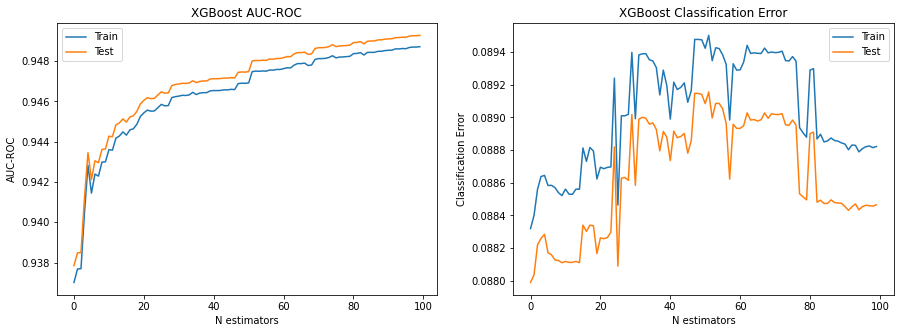

<Figure size 432x288 with 0 Axes>

In [ ]:
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('Classification Report:')
print(classification_report(y_test,pred_test))
graph_metrics(modelXGB,"XGBoost")

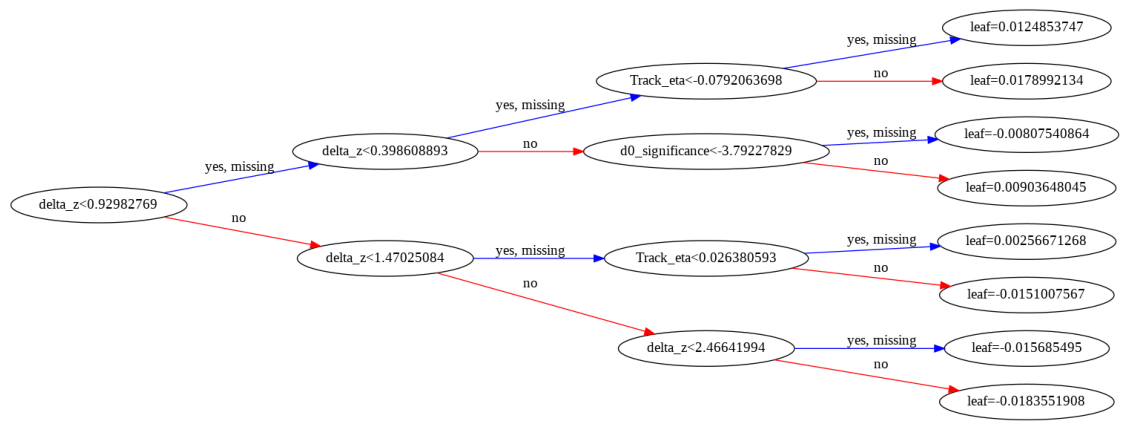

In [ ]:
# Create the feature importances plot on tree to show to Physical specialist
fig, ax = plt.subplots(figsize=(20,20))
plot_tree(modelXGB,ax = ax, rankdir='LR')
plt.show()

In [ ]:
import torch
# save the model to disk
def save_model(filename,model):
  path = F"/content/drive/Shared drives/ATLAS project/models/{filename}" 
  torch.save(model, path)

In [ ]:
save_model('model__with_all_features_and_7_xAOD_and_cut_on_2.sav',modelXGB)

In [ ]:
def load_model(filename):
  # load the model from disk
  path = F"/content/drive/Shared drives/ATLAS project/models/{filename}"
  return torch.load(path)

In [ ]:
modelXGB = load_model('model_XGBoost_with_all_features_and_7_xAOD_and_cut_on_2.sav')
pred_train,pred_test = predict(modelXGB)
get_score(y_train,pred_train,y_test,pred_test)

#############scores on train set################
confusion matrix:  [[375116  57225]
 [ 59150 818718]]
tn: 375116 fp: 57225 fn: 59150 tp: 818718
Error rate:  0.08882170707116192
Accuracy:  0.9111782929288381
Sensitivity(tpr):  0.9326208496038129
Specificity:  0.8676392014636595
False positive rate:  0.13236079853634053
roc_auc score:  0.9001300255337362

#############scores on test set################
confusion matrix:  [[185953  28189]
 [ 28900 402286]]
tn: 185953 fp: 28189 fn: 28900 tp: 402286
Error rate:  0.08846509062058364
Accuracy:  0.9115349093794164
Sensitivity(tpr):  0.9329755604309973
Specificity:  0.868363048818074
False positive rate:  0.131636951181926
roc_auc score:  0.9006693046245358


# The research question
After performing the model we want to use a correlation matrix to identify the state of our data after training. Having seen above that the indices provide in terms of accuracy, tpr and ROC AUC we want to understand if when we cut the data in the omega variable we will reduce the number of False positive (fp) * which will aim for zero. The number of fp in relation to the amount of false we saw in the graph above is significant to us, so although we are interested in the FPR index and the amount of fp in relation to the omega cross section.
* False positive (fp) - The amount of records we have classified as true even though their classification is false.

0.0
fp: 11843
fp/fp+tn (fpr): 1.0
fn: 0
fn/fn+tp (fnr): 0.0
fp+fn/tp+tn+fn+fp (err): 0.04624546058026475
tp+tn/tp+tn+fn+fp (acc): 0.9537545394197352
0.1
fp: 7781
fp/fp+tn (fpr): 0.9969250480461243
fn: 12
fn/fn+tp (fnr): 0.0001159375483073118
fp+fn/tp+tn+fn+fp (err): 0.07001230807931075
tp+tn/tp+tn+fn+fp (acc): 0.9299876919206893
0.2
fp: 4538
fp/fp+tn (fpr): 0.8411492122335495
fn: 1754
fn/fn+tp (fnr): 0.045062172438598294
fp+fn/tp+tn+fn+fp (err): 0.14197071233556713
tp+tn/tp+tn+fn+fp (acc): 0.8580292876644329
0.3
fp: 2139
fp/fp+tn (fpr): 0.47228968867299626
fn: 3881
fn/fn+tp (fnr): 0.2493895386197147
fp+fn/tp+tn+fn+fp (err): 0.29963665322781347
tp+tn/tp+tn+fn+fp (acc): 0.7003633467721866
0.4
fp: 778
fp/fp+tn (fpr): 0.16731182795698923
fn: 3695
fn/fn+tp (fnr): 0.5144090213002923
fp+fn/tp+tn+fn+fp (err): 0.37801064818727287
tp+tn/tp+tn+fn+fp (acc): 0.6219893518127271
0.5
fp: 441
fp/fp+tn (fpr): 0.08553141970519783
fn: 2732
fn/fn+tp (fnr): 0.6789264413518886
fp+fn/tp+tn+fn+fp (err): 0.3456

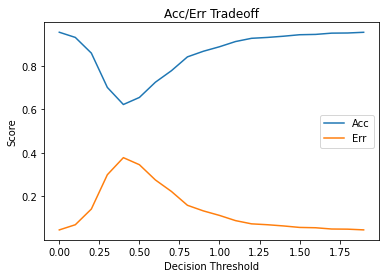

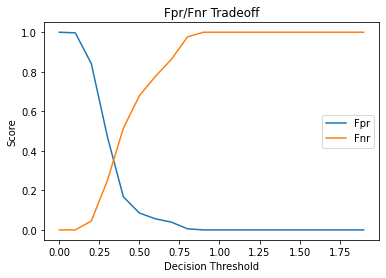

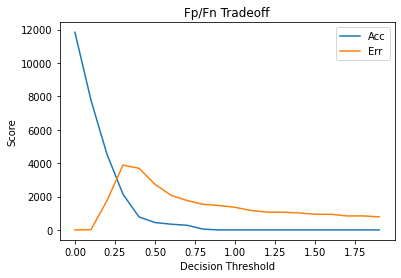

In [ ]:
# def metric_treshold_omega_var(X_test,y_test,pred_test):
_fp = []
_fn = []
_fpr = []
_fnr = [] 
_err = []
_acc = []
tresholds=[]
data_test = X_test.copy()
data_test['y'] = y_test.copy() 
data_test['pred'] = pred_test.copy()
x_te = data_test.loc[:,'EventNumber':'sin_teta']
y_te = data_test[['y']]
pred_te = data_test[['pred']]  
for i in np.linspace(0,1.9,num=20):
  treshold = round(i,1)
  print(treshold)
  tresholds.append(treshold)
  c_X,c_y,c_pred = get_cut_data_by_treshold(x_te.copy(),y_te.copy(),pred_te.copy(),False,'y',treshold)  
  confm = confusion_matrix(c_y, c_pred)
  tn, fp, fn, tp = confm.ravel()
  _fp.append(fp)
  print("fp:",fp)
  _fpr.append(fp/(fp+tn))
  print("fp/fp+tn (fpr):",fp/(fp+tn))
  _fn.append(fn) 
  print("fn:",fn)
  _fnr.append(fn/(fn+tp))
  print("fn/fn+tp (fnr):",fn/(fn+tp))
  _err.append((fp + fn) / (tp + tn + fn + fp))
  print("fp+fn/tp+tn+fn+fp (err):",(fp + fn) / (tp + tn + fn + fp))
  _acc.append((tp + tn) / (tp + tn + fn + fp))
  print("tp+tn/tp+tn+fn+fp (acc):",(tp + tn) / (tp + tn + fn + fp))
create_graph(_acc,_err,tresholds,'Acc', 'Err','Acc/Err Tradeoff')
create_graph(_fpr,_fnr,tresholds,'Fpr', 'Fnr','Fpr/Fnr Tradeoff')
create_graph(_fp,_fn,tresholds,'Acc', 'Err','Fp/Fn Tradeoff')

# feature importance
We received the model variables from physical experts but did not have an understanding and knowledge of what the significant variables were to create the data for the model. Therefore after using the physical knowledge we want to examine through technological tools what the significant variables are.

In [ ]:
from sklearn.feature_selection import SelectFromModel
from xgboost import plot_importance
import matplotlib.pyplot as plt
from numpy import sort
from sklearn.metrics import accuracy_score

# define custom class to fix bug in xgboost 1.0.2
class MyXGBClassifier(XGBClassifier):
	@property
	def coef_(self):
		return None
		
def features_selection(model,newModel):
	# feature importance
	print(model.feature_importances_)
	# Fit model using each importance as a threshold
	plot_importance(model)
	plt.show()
	thresholds = sort(model.feature_importances_)
	for thresh in thresholds:
		# select features using threshold
		selection = SelectFromModel(model, threshold=thresh, prefit=True)
		select_X_train = selection.transform(X_train)
  	# train model
		selection_model=newModel
		selection_model.fit(select_X_train, y_train)
  	# eval model
		select_X_test = selection.transform(X_test)
  	# y_pred = selection_model.predict(select_X_test)
  	# predictions = [round(value) for value in y_pred]
		predictions = selection_model.predict(select_X_test)
		accuracy = accuracy_score(y_test, predictions)
		print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

-------------NewXGBClassifier------------
[0.         0.02025693 0.0460102  0.         0.         0.01661254
 0.         0.05635181 0.8607685  0.        ]


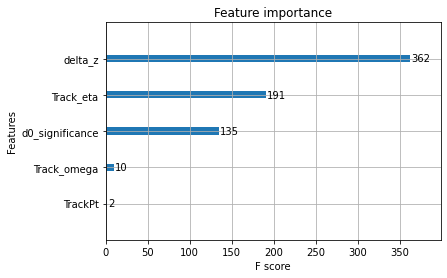

Thresh=0.000, n=10, Accuracy: 91.15%
Thresh=0.000, n=10, Accuracy: 91.15%
Thresh=0.000, n=10, Accuracy: 91.15%
Thresh=0.000, n=10, Accuracy: 91.15%
Thresh=0.000, n=10, Accuracy: 91.15%
Thresh=0.017, n=5, Accuracy: 91.15%
Thresh=0.020, n=4, Accuracy: 91.16%
Thresh=0.046, n=3, Accuracy: 91.22%
Thresh=0.056, n=2, Accuracy: 91.16%
Thresh=0.861, n=1, Accuracy: 89.95%



In [ ]:
from xgboost import XGBClassifier
print("-------------NewXGBClassifier------------")
newModelXGBOOST=XGBClassifier(n_estimator=400, random_state=1,learning_rate=0.01,min_child_weight=1, scale_pos_weight=count_f/count_t)
features_selection(modelXGB, newModelXGBOOST)
print("\r\r\r\r")